In [17]:
# %pip install tensorboard  # uncomment if you don't have it

import os, re
from glob import glob
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

def latest_version_dir(logdir: str) -> str:
    """Pick the latest 'version_X' directory under logdir."""
    candidates = [d for d in glob(os.path.join(logdir, "version_*")) if os.path.isdir(d)]
    if not candidates:
        raise FileNotFoundError(f"No 'version_*' runs found under: {logdir}")
    candidates.sort(key=lambda p: int(re.findall(r"version_(\d+)", p)[0]))
    return candidates[-1]

def load_event_accumulator(run_dir: str) -> event_accumulator.EventAccumulator:
    ea = event_accumulator.EventAccumulator(run_dir)
    ea.Reload()
    return ea

def find_first_existing_tag(all_tags, candidates):
    """Return the first tag that exists in all_tags; else None."""
    for t in candidates:
        if t in all_tags:
            return t
    return None

def get_scalar(ea, tag):
    """Return (steps, values) for a scalar tag, or ([],[]) if missing."""
    if tag is None:
        return [], []
    evts = ea.Scalars(tag)
    steps = [e.step for e in evts]
    vals  = [e.value for e in evts]
    return steps, vals

def to_epoch_x(steps, vals):
    """Many PL metrics are logged once/epoch; map to 0..N-1 for clean x-axis."""
    if not steps:
        return [], []
    xs = list(range(len(vals)))
    ys = vals
    return xs, ys

def plot_run(run_dir: str, show_acc: bool = True, title: str = None):
    ea = load_event_accumulator(run_dir)
    scalar_tags = set(ea.Tags().get("scalars", []))

    # Try common tag names (adjust if your logs differ)
    tag_map = {
        "train_loss": find_first_existing_tag(scalar_tags, [
            "train_loss", "train/loss", "loss/train", "train/loss_epoch"
        ]),
        "val_loss": find_first_existing_tag(scalar_tags, [
            "val_loss", "val/loss", "loss/val", "val/loss_epoch"
        ]),
        "train_acc": find_first_existing_tag(scalar_tags, [
            "train/acc_safe", "acc/train", "train_acc_safe"
        ]),
        "val_acc": find_first_existing_tag(scalar_tags, [
            "val/acc_safe", "acc/val", "val_acc_safe"
        ]),
    }

    # --- Loss plot ---
    tr_steps, tr_vals = get_scalar(ea, tag_map["train_loss"])
    va_steps, va_vals = get_scalar(ea, tag_map["val_loss"])
    tr_x, tr_y = to_epoch_x(tr_steps, tr_vals)
    va_x, va_y = to_epoch_x(va_steps, va_vals)

    plt.figure(figsize=(7, 4))
    if tr_y: plt.plot(tr_x, tr_y, label=f"train_loss ({tag_map['train_loss']})")
    if va_y: plt.plot(va_x, va_y, label=f"val_loss ({tag_map['val_loss']})")
    plt.xlabel("epoch"); plt.ylabel("loss")
    plt.title(title or f"Loss — {os.path.basename(run_dir)}")
    plt.legend(); plt.tight_layout()
    plt.show()

    # --- Accuracy plot (optional) ---
    if show_acc:
        ta_steps, ta_vals = get_scalar(ea, tag_map["train_acc"])
        vaa_steps, vaa_vals = get_scalar(ea, tag_map["val_acc"])
        ta_x, ta_y = to_epoch_x(ta_steps, ta_vals)
        vaa_x, vaa_y = to_epoch_x(vaa_steps, vaa_vals)

        if ta_y or vaa_y:
            plt.figure(figsize=(7, 4))
            if ta_y:  plt.plot(ta_x, ta_y, label=f"train_acc ({tag_map['train_acc']})")
            if vaa_y: plt.plot(vaa_x, vaa_y, label=f"val_acc ({tag_map['val_acc']})")
            plt.xlabel("epoch"); plt.ylabel("accuracy")
            plt.title(title or f"Accuracy — {os.path.basename(run_dir)}")
            plt.legend(); plt.tight_layout()
            plt.show()
        else:
            print("No accuracy tags found to plot.")

def list_runs(log_root="lightning_logs"):
    versions = sorted(glob(os.path.join(log_root, "version_*")),
                      key=lambda p: int(re.findall(r"version_(\d+)", p)[0]) if re.findall(r"version_(\d+)", p) else -1)
    for v in versions:
        print(v)

Using run: src/lightning_logs/version_43


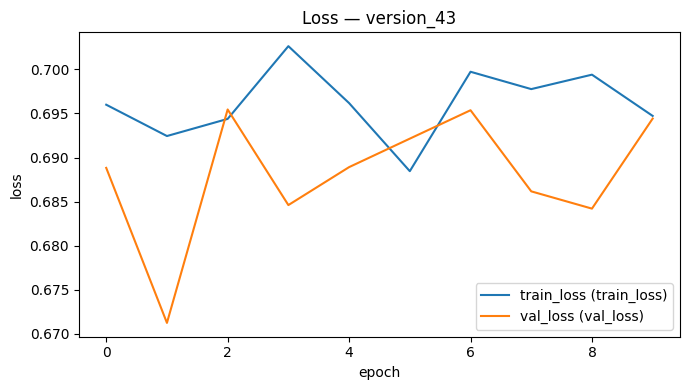

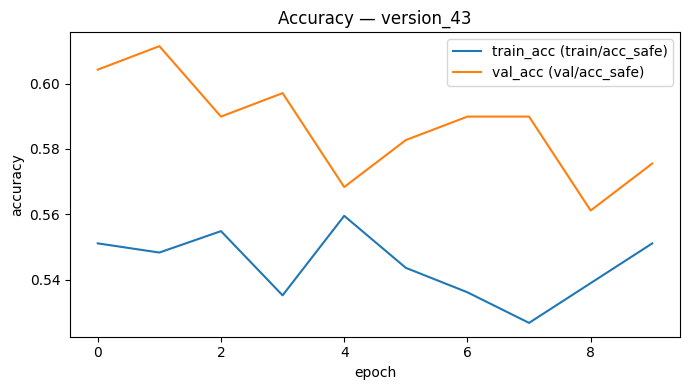

In [20]:
LOG_ROOT = "src/lightning_logs"

# Show available runs:
#list_runs(LOG_ROOT)

# Use latest:
RUN_DIR = latest_version_dir(LOG_ROOT)
print("Using run:", RUN_DIR)

plot_run(RUN_DIR, show_acc=True, title=None)